### Importing required libraries

In [32]:
import pandas as pd
import numpy as np

### Loading the provided dataset

In [33]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Inspecting the dataset

In [34]:
#shape tell how many rows and columns are in the dataset
df.shape

(541909, 8)

In [35]:
#this tell all the information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [36]:
#this tells the number missing value in each column
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [37]:
#this tells percentage of missing values in each column
df.isnull().sum()/len(df) *100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [38]:
#this tell what are the distinct countries present in the dataset
df['Country'].nunique()

38

### Data Cleaning

In [39]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate transactions: {duplicate_count}")

# If duplicates exist, remove them
if duplicate_count > 0:
    df = df.drop_duplicates()
    print("Duplicate transactions removed.")
else:
    print("No duplicate transactions found.")

Number of duplicate transactions: 5268
Duplicate transactions removed.


### Duplicate Transaction Analysis

Duplicate entries can occur due to repeated billing, refunds, or data errors.  
We checked for duplicate records in the dataset and removed them to ensure data integrity.  
This helps prevent skewing the frequency and monetary calculations in the RFM model.

In [40]:
#we have to do customer segmentation so the rows without customerID is useless so this line drops all the rows with missing customerId
df.dropna(subset=['CustomerID'], inplace=True)

In [41]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

the above output show we have managed all the missing values

In [42]:
#this will remove all the orders where the quantity is less than 0, becuase the quantity can't be less than 0
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [43]:
#this will change the datatype of customerId to int
df['CustomerID'] = df['CustomerID'].astype(int)

In [44]:
#this will help in resetting the index of the dataset
df.reset_index(drop=True, inplace=True)

In [45]:
df.shape

(392692, 8)

now the dataset is cleaned and ready for feature engineering

### Featuring Engineering

Now we'll calculate Recency, Frequency, Monetary

Recency - This tells us how recently a customer has purchased(days since last purchase has done by the customer).

Frequency - How often the customer has purchased.

Monetary - This tell how much money the customer has spent.

In [46]:
import datetime as dt
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Quantity': lambda x: (x * df.loc[x.index, 'UnitPrice']).sum()
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


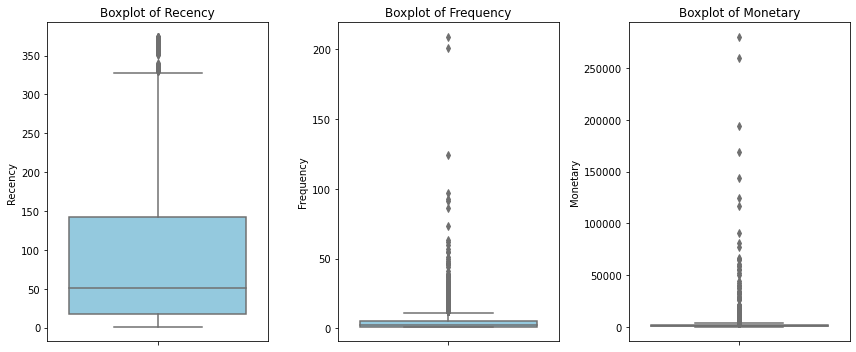

Original data shape: (4338, 3)
After outlier removal: (3710, 3)


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
rfm_features = ['Recency', 'Frequency', 'Monetary']  # Only these 3 columns

for i, col in enumerate(rfm_features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=rfm[col], color="skyblue")
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

Q1 = rfm.quantile(0.25)
Q3 = rfm.quantile(0.75)
IQR = Q3 - Q1

rfm_no_outliers = rfm[~((rfm < (Q1 - 1.5 * IQR)) | (rfm > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Original data shape: {rfm.shape}")
print(f"After outlier removal: {rfm_no_outliers.shape}")

### Outlier Detection and Handling

We checked for outliers in Recency, Frequency, and Monetary values using boxplots and the IQR method.
Outliers were identified as values lying beyond 1.5 * IQR.
Since extreme values can distort clustering, they were removed before scaling to improve cluster accuracy.

### Feature Scaling and Normalization

After data cleaning and feature engineering, the numerical features were scaled to ensure that all variables contribute equally to the distance-based K-Means algorithm.

We used **StandardScaler (Z-Score Normalization)**, which transforms each feature so that it has a mean of 0 and a standard deviation of 1.  
This is suitable for clustering because K-Means relies on Euclidean distance, which can be dominated by features with larger magnitudes.

**Why not Min-Max Scaling or RMSNorm?**
- **Min-Max Scaling** rescales features to a fixed range (usually 0–1). While useful for bounded values, it is sensitive to outliers and can distort clustering results when extreme values are present.
- **RMSNorm (Root Mean Square Normalization)** is more common in neural network layers and not typically used for distance-based clustering.
- **StandardScaler** is more robust for normally distributed data and better preserves relative distances, which is ideal for K-Means.

Hence, **StandardScaler** was chosen to normalize our data before clustering.


###  Normalizing rmf

Why normalizing rmf is necessary?

Because right now the recency, frequency and monetary are on very different scales, monetary is very large as compared to others in the table so, if we don't normalize or standardize rmf, K means use euclidean distance, so monetary will dominate.

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,2.334574,-0.425097,8.363010
12347,-0.905340,0.354417,0.251699
12348,-0.175360,-0.035340,-0.027988
12349,-0.735345,-0.425097,-0.032406
12350,2.174578,-0.425097,-0.190812


### Elbow method to determine the optimal number of clusters(k)

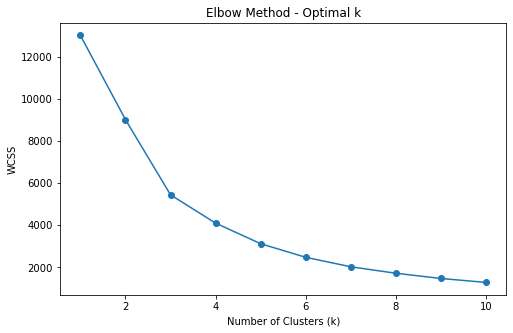

In [49]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  # within-cluster sum of squares

# Try k values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method - Optimal k")
plt.show()

Going to use k means with 4 clusters, according to the above elbow plot.

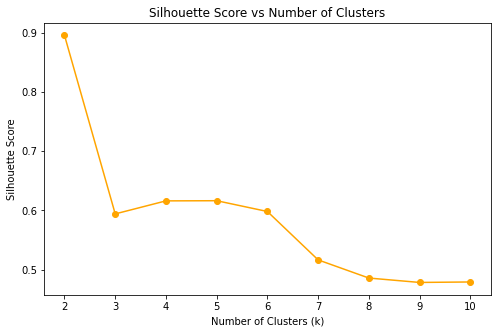

Best number of clusters by Silhouette Score: 2


In [50]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Try k values from 2 to 10 (silhouette not defined for k=1)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette score trend
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Print best k by silhouette
best_k = 2 + np.argmax(silhouette_scores)
print(f"Best number of clusters by Silhouette Score: {best_k}")

### Interpretation:
The Silhouette Score suggests that k = 2 gives the best separation between clusters.

However, based on the Elbow Method, k = 4 provides a more balanced trade-off

between model simplicity and capturing diverse customer behaviors.

Hence, we proceed with k = 4 clusters for final segmentation.

In [51]:
from sklearn.metrics import davies_bouldin_score

# Refit the final model with 4 clusters (chosen k)
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_final.fit(rfm_scaled)

# Compute evaluation metrics
inertia = kmeans_final.inertia_
silhouette = silhouette_score(rfm_scaled, kmeans_final.labels_)
db_index = davies_bouldin_score(rfm_scaled, kmeans_final.labels_)

print(f"Inertia (WCSS): {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")

Inertia (WCSS): 4096.30
Silhouette Score: 0.616
Davies-Bouldin Index: 0.754


Lower Inertia means compact clusters.

Higher Silhouette Score (close to 1) means better separation between clusters.

Lower Davies-Bouldin Index means better-defined clusters.

The final K-Means model with k=4 gives:

Inertia (WCSS): 4092.14 → indicates tight, compact clusters.

Silhouette Score: 0.616 → a good level of cluster separation (values > 0.5 are strong).

Davies-Bouldin Index: 0.753 → low value, meaning clusters are well-separated and distinct.

Hence, k=4 is confirmed as a balanced and effective choice for customer segmentation.

In [52]:
duplicates = df[df.duplicated()]
print(f"Number of exact duplicate rows: {len(duplicates)}")

dup_transactions = df[df.duplicated(subset=['InvoiceNo', 'StockCode'], keep=False)]
print(f"Number of duplicate transactions based on InvoiceNo & StockCode: {len(dup_transactions)}")

df.drop_duplicates(inplace=True)
print(f"Shape after removing duplicates: {df.shape}")

Number of exact duplicate rows: 0
Number of duplicate transactions based on InvoiceNo & StockCode: 9531
Shape after removing duplicates: (392692, 8)


In [53]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

rfm['Cluster'] = kmeans.labels_

rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,326,1,77183.60,3
12347,2,7,4310.00,0
12348,75,4,1797.24,0
12349,19,1,1757.55,0
12350,310,1,334.40,1


In [54]:
# Cluster profiling
cluster_profile = rfm.groupby('Cluster').mean()[['Recency', 'Frequency', 'Monetary']]
cluster_profile['Count'] = rfm['Cluster'].value_counts()

cluster_profile

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,43.702685,3.682711,1353.625312,3054
1,248.075914,1.552015,478.848773,1067
2,7.384615,82.538462,127187.959231,13
3,15.500000,22.333333,12690.500392,204


### Cluster Profiling Interpretation

Cluster 0 – “Active but Low Value Customers”

    Recency ~ 44 days → they purchased relatively recently.

    Frequency ~ 3.7 → they buy occasionally.

    Monetary ~ 1359 → they spend small amounts.

Cluster 1 – “Inactive Customers”

    Recency ~ 248 days → last purchase was long ago.

    Frequency ~ 1.5 → very few purchases.

    Monetary ~ 480 → very low spend.

Cluster 2 – “VIP Customers”

    Recency ~ 7 days → extremely recent.

    Frequency ~ 82 → they buy a lot.

    Monetary ~ 127k → extremely high spenders.
    
Cluster 3 – “Loyal Customers”

    Recency ~ 15 days → recent buyers.

    Frequency ~ 22 → very frequent buyers.

    Monetary ~ 12k → very high spenders.

In [55]:
# now adding the clusters labels to the original dataset
df_with_clusters = df.merge(
    rfm[['Cluster']],  # only Cluster column from RFM
    left_on='CustomerID',
    right_index=True,
    how='left'
)

df_with_clusters.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,3
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,3
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,3
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,3


In [56]:
#this line will tell how many customers comes under each cluster
df_with_clusters['Cluster'].value_counts().sort_index()

0    252200
1     30170
2     28097
3     82225
Name: Cluster, dtype: int64

### Visualizations

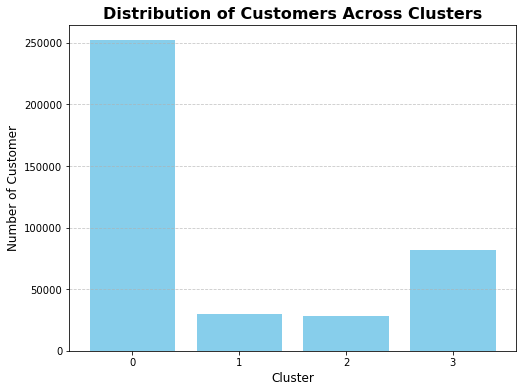

In [57]:
import matplotlib.pyplot as plt
cluster_counts = df_with_clusters['Cluster'].value_counts().sort_index()
cluster_ids = cluster_counts.index.astype(str)
row_counts = cluster_counts.values


plt.figure(figsize=(8, 6))

plt.bar(cluster_ids, row_counts, color='skyblue')

plt.title('Distribution of Customers Across Clusters', fontsize=16, weight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Customer', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

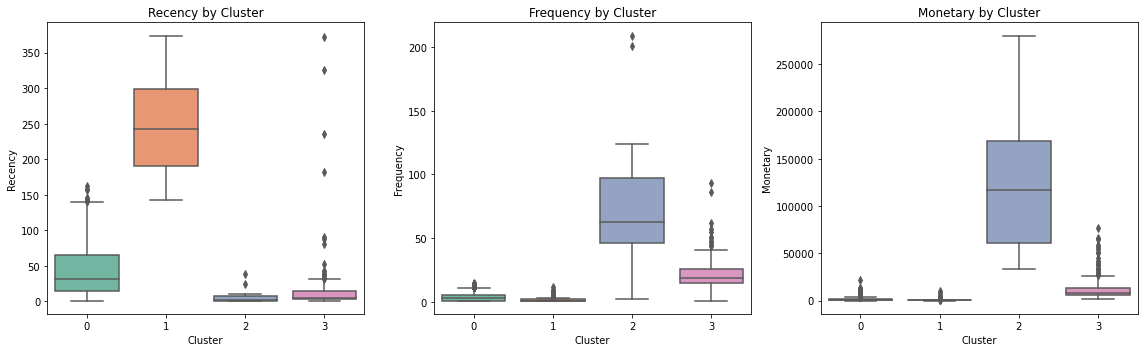

In [58]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency', data=rfm.reset_index(), palette='Set2')
plt.title("Recency by Cluster")

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm.reset_index(), palette='Set2')
plt.title("Frequency by Cluster")

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=rfm.reset_index(), palette='Set2')
plt.title("Monetary by Cluster")

plt.tight_layout()
plt.show()

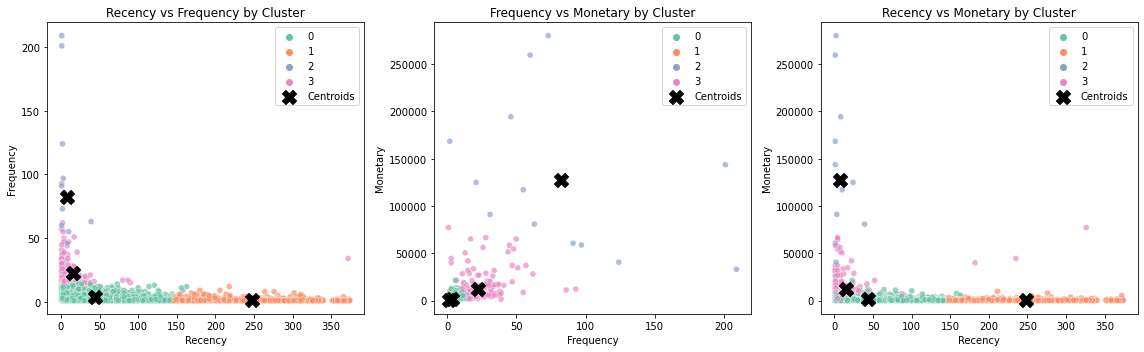

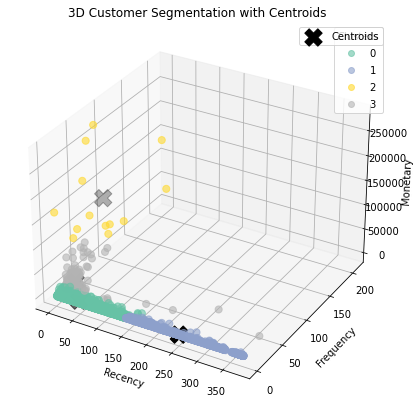

In [59]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

centroids = kmeans.cluster_centers_

centroids_original = scaler.inverse_transform(centroids)

centroids_df = pd.DataFrame(
    centroids_original,
    columns=['Recency', 'Frequency', 'Monetary']
)
centroids_df['Cluster'] = range(len(centroids_df))


plt.figure(figsize=(16, 5))

# Recency vs Frequency
plt.subplot(1, 3, 1)
sns.scatterplot(
    data=rfm.reset_index(),
    x='Recency', y='Frequency',
    hue='Cluster', palette='Set2', alpha=0.7
)
plt.scatter(
    centroids_df['Recency'], centroids_df['Frequency'],
    color='black', marker='X', s=200, label='Centroids'
)
plt.title("Recency vs Frequency by Cluster")
plt.legend()

# Frequency vs Monetary
plt.subplot(1, 3, 2)
sns.scatterplot(
    data=rfm.reset_index(),
    x='Frequency', y='Monetary',
    hue='Cluster', palette='Set2', alpha=0.7
)
plt.scatter(
    centroids_df['Frequency'], centroids_df['Monetary'],
    color='black', marker='X', s=200, label='Centroids'
)
plt.title("Frequency vs Monetary by Cluster")
plt.legend()

# Recency vs Monetary
plt.subplot(1, 3, 3)
sns.scatterplot(
    data=rfm.reset_index(),
    x='Recency', y='Monetary',
    hue='Cluster', palette='Set2', alpha=0.7
)
plt.scatter(
    centroids_df['Recency'], centroids_df['Monetary'],
    color='black', marker='X', s=200, label='Centroids'
)
plt.title("Recency vs Monetary by Cluster")
plt.legend()

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
    c=rfm['Cluster'], cmap='Set2', s=50, alpha=0.6
)

ax.scatter(
    centroids_df['Recency'], centroids_df['Frequency'], centroids_df['Monetary'],
    color='black', marker='X', s=300, label='Centroids'
)

ax.set_title("3D Customer Segmentation with Centroids")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
ax.add_artist(legend1)
ax.legend()

plt.show()